In [1]:
#NBVAL_IGNORE_OUTPUT
import pandas as pd
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

from src import data_proc
%load_ext autoreload
%autoreload 2

# Load Data

In [51]:
load_data_path = "../data/raw_data/load_hist.csv"
temp_data_path = '../data/raw_data/temp_hist.csv'

load_data_raw = pd.read_csv(load_data_path, parse_dates=[0])
temp_data_raw = pd.read_csv(temp_data_path, parse_dates=[0])
# print(load_data_raw.Date[0])

# view_n = 3
# # print(temp_data_raw.head(view_n), '\n', load_data_raw.head(view_n))
# # print(temp_data_raw.shape, load_data_raw.shape)

temp_data_raw.columns = ['date', 'hr', 'station_id', 'temperature']
load_data_raw.columns = ['date', 'hr', 'load']


# temp_data_raw['datetime'] = temp_data_raw.date + pd.to_timedelta(temp_data_raw.hr, unit='h')
load_data_raw['datetime'] = load_data_raw.date + pd.to_timedelta(load_data_raw.hr, unit='h')
# print(temp_data_raw.datetime.value_counts())
temp_data_raw = temp_data_raw[temp_data_raw.date < '2008']
temp_data_raw.tail(2)

,date,hr,station_id,temperature
973006,2007-12-31,23,28,42
973007,2007-12-31,24,28,37


Each row in the laod data is a load data for a given hour

In [52]:
import numpy as np

temp_data_raw['datetime'] = temp_data_raw.date + pd.to_timedelta(temp_data_raw.hr, unit='h')    
temp_data_raw['dummy_col_01'] = np.arange(len(temp_data_raw)) % 2

# temp_data_raw['dummy_col_01'] = np.arange(len(temp_data_raw)) % 2

temp_data_pivot = pd.pivot_table(temp_data_raw, values='temperature', index=['date', 'hr','datetime', 'dummy_col_01'], columns='station_id')
temp_data_pivot.reset_index(inplace=True)
temp_data_pivot.drop(labels=['dummy_col_01', 'date', 'hr'], axis=1, inplace=True)
temp_data_pivot.head()
str_temp_cols_dict = dict([( col, 't'+str(col)) for col in temp_data_pivot.columns if isinstance(col, int)])
temp_data_pivot.rename(columns=str_temp_cols_dict, inplace=True)
temp_data_pivot.head(2)

station_id,datetime,t1,t2,t3,t4,t5,t6,t7,t8,t9,...,t19,t20,t21,t22,t23,t24,t25,t26,t27,t28
0,2005-01-01 01:00:00,43,46,40,47,48,46,44,52,45,...,39,50,43,45,50,47,41,47,47,45
1,2005-01-01 02:00:00,41,46,38,46,48,45,51,50,42,...,41,49,43,46,47,47,45,47,47,45


In [53]:
np.all(load_data_raw.datetime == temp_data_pivot.datetime)

True

# Exploratory Analysis

<AxesSubplot:xlabel='datetime'>

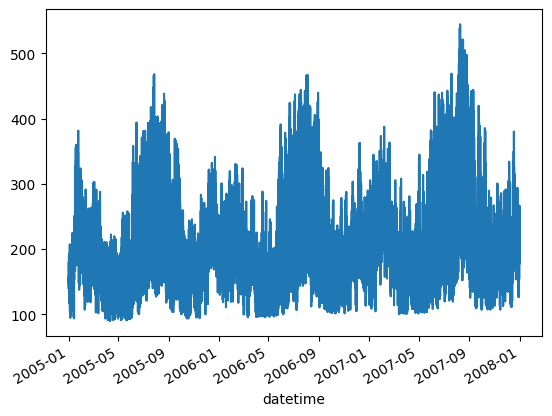

In [64]:
load_data_raw.set_index('datetime').load.plot()

<AxesSubplot:xlabel='datetime'>

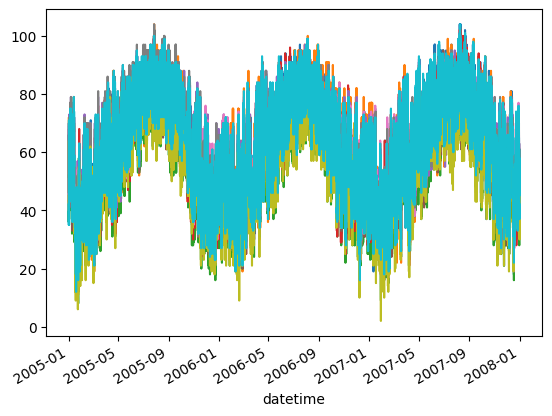

In [55]:
temp_data_pivot.set_index('datetime').iloc[:, :10].plot(legend=False)

## Demand by Time

### Demand by Month of year

<AxesSubplot:xlabel='month', ylabel='load'>

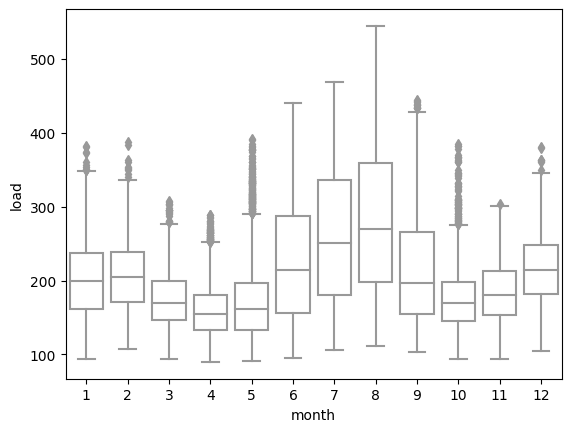

In [56]:
temp_df = (load_data_raw.copy()
           .assign(month = load_data_raw.datetime.dt.month)
           )



sns.boxplot(x='month', y='load', data=temp_df, color='w')

### day of week

<AxesSubplot:xlabel='day_of_wk', ylabel='load'>

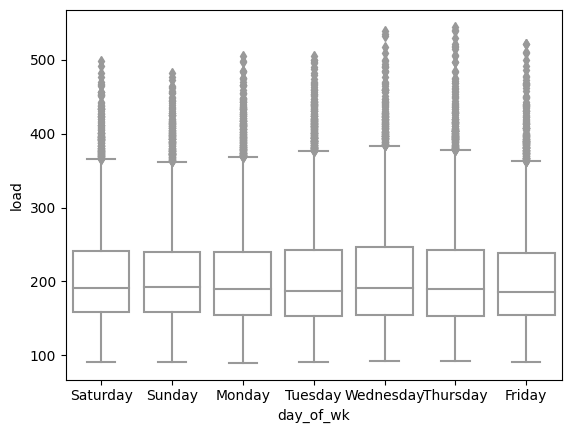

In [57]:
temp_df = (load_data_raw.copy()
           .assign(day_of_wk = load_data_raw.datetime.dt.day_name())
           )


sns.boxplot(x='day_of_wk', y='load', data=temp_df, color='w')

### hour of day

<AxesSubplot:xlabel='hr', ylabel='load'>

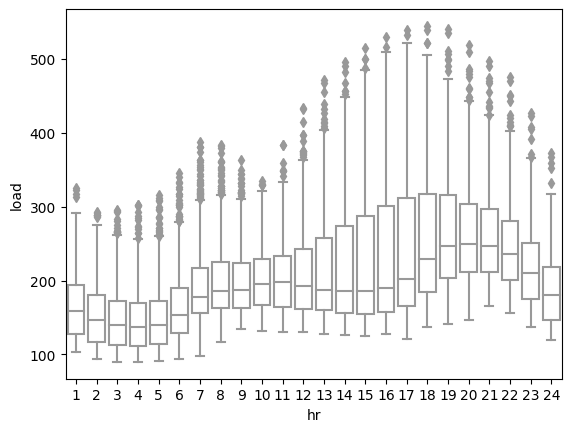

In [58]:


sns.boxplot(x='hr', y='load', data=temp_df, color='w')

#### Weekend?

<AxesSubplot:xlabel='hr', ylabel='load'>

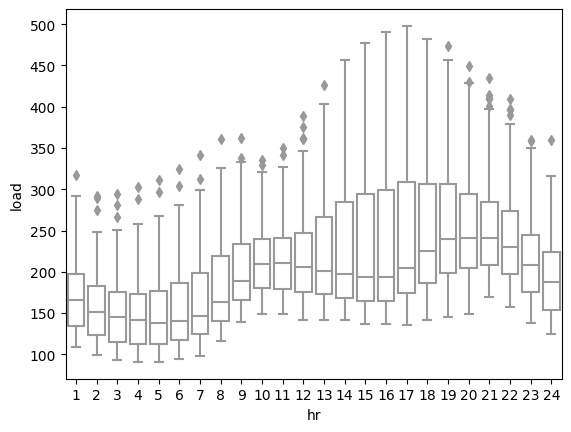

In [59]:
temp_df = (load_data_raw.copy()
           .assign(is_weekend = np.uint8(load_data_raw.datetime.dt.day_of_week > 4))
           .query('is_weekend==1'))


sns.boxplot(x='hr', y='load', data=temp_df, color='w')

## Correlations

### load and temp

<AxesSubplot:xlabel='temp', ylabel='load'>

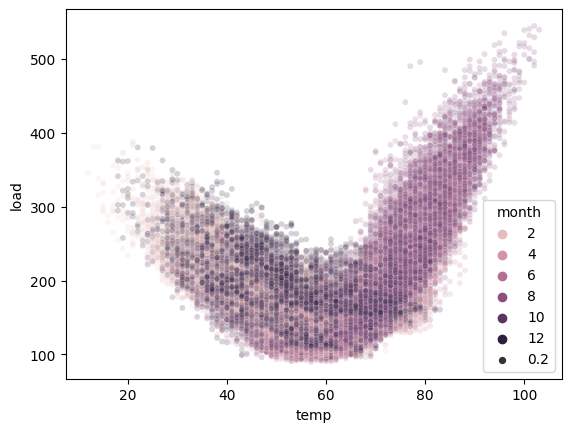

In [60]:
temp_df = (load_data_raw.copy()
           .assign(temp = temp_data_pivot.iloc[:, 4])
           .assign(month = load_data_raw.datetime.dt.month)
           )

sns.scatterplot(x='temp', y='load', data=temp_df, alpha=0.2, size=0.2, hue='month')

### Load and lags
Due to buildings’ thermal inertia, it is important to consider lagged temperatures as well as current temperatures

<AxesSubplot:xlabel='lag24', ylabel='load'>

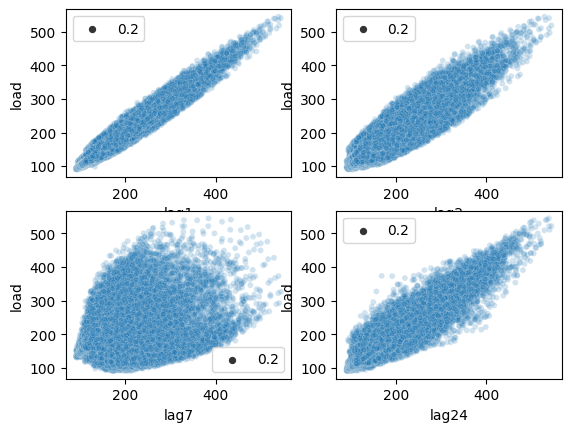

In [61]:
temp_df = (load_data_raw.copy()
           .assign(lag1=load_data_raw.load.shift(1))
           .assign(lag2=load_data_raw.load.shift(2))
           .assign(lag7=load_data_raw.load.shift(7))
           .assign(lag24=load_data_raw.load.shift(24))
           )


fig, axs = plt.subplots(2,2)

sns.scatterplot(x='lag1', y='load', data=temp_df, alpha=0.2, size=0.2, ax=axs[0,0])
sns.scatterplot(x='lag2', y='load', data=temp_df, alpha=0.2, size=0.2, ax=axs[0,1])
sns.scatterplot(x='lag7', y='load', data=temp_df, alpha=0.2, size=0.2, ax=axs[1,0])
sns.scatterplot(x='lag24', y='load', data=temp_df, alpha=0.2, size=0.2, ax=axs[1,1])

### load and daylight

In [62]:
#NBVAL_IGNORE_OUTPUT
def hours_of_daylight(date, axis=23.44, latitude=35.76):
    """Compute the hours of daylight for the given date"""
    diff = date - pd.datetime(2000, 12, 21)
    day = diff.total_seconds() / 24. / 3600
    day %= 365.25
    m = 1. - np.tan(np.radians(latitude)) * np.tan(np.radians(axis) * np.cos(day * np.pi / 182.625))
    m = max(0, min(m, 2))
    return 24. * np.degrees(np.arccos(1 - m)) / 180.

temp_df = (load_data_raw.copy()
           .assign(daylight_hrs= load_data_raw.datetime.apply(hours_of_daylight)))


# sns.lineplot('daylight_hrs', data=temp_df)

c:\Users\Aroge\Documents\Projects\data science projects\electricity-consumption-prediction-api\.env\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  after removing the cwd from sys.path.


<AxesSubplot:xlabel='daylight_hrs', ylabel='load'>

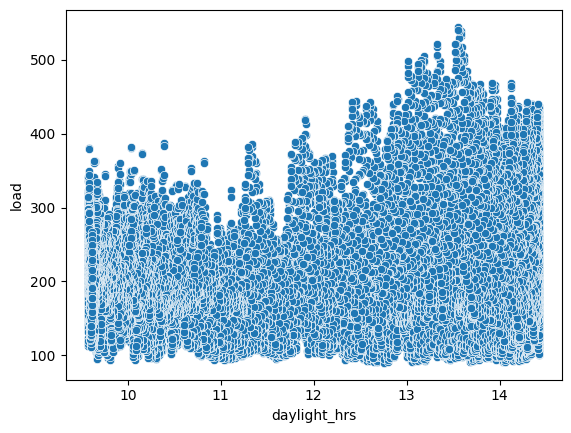

In [67]:
fig, ax = plt.subplots()
sns.scatterplot(x=temp_df.daylight_hrs, y=temp_df.load)